<a href="https://colab.research.google.com/github/ensf411-winter-2022/dl-lab3-ryanbakerucalgary/blob/main/lab3_train_finger_count.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [83]:
!pip install -q fastbook

import fastbook
fastbook.setup_book()

In [84]:
from fastai.vision.all import *

# 1. Data loading and augmentation

Create a DataBlock and DataLoaders using:
- Training and validation images collected in Lab2
- `Resize(640)` as item transform
- A size of 420 in the batch transforms
- Use a batch size of 32
- Use `set_seed()` to obtain reproducible results.
- Augmentations you find useful (see question 1)

Show a training and a validation batch.
Show augmentations, i.e. `show_batch()` with `unique=True`.

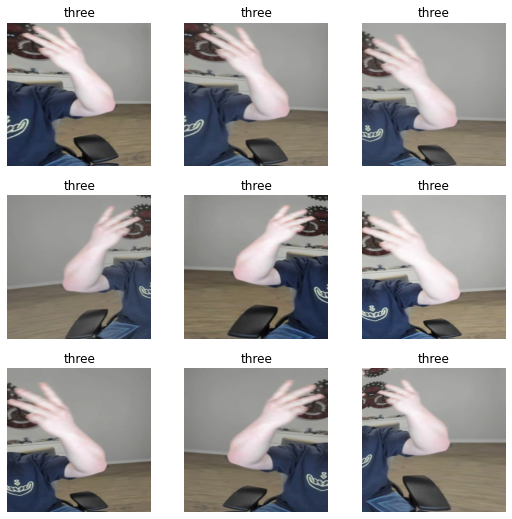

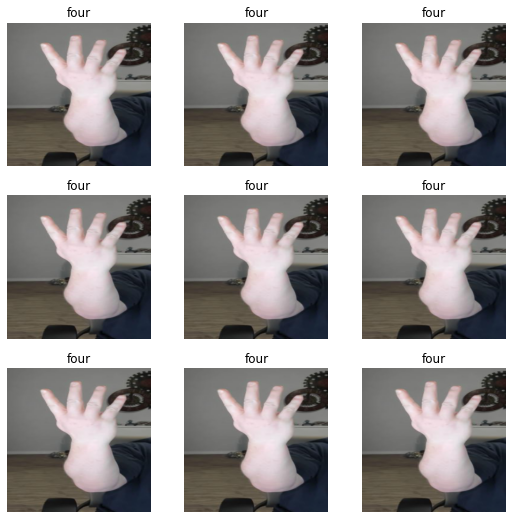

In [85]:
path = Path('/content/gdrive/MyDrive/ColabNotebooks/digits')

seed_val = 25
set_seed(seed_val)

def get_parent_as_list(x): return [parent_label(x)]
fingers = DataBlock(
    blocks=(ImageBlock, CategoryBlock), #image->discrete category
    # blocks=(ImageBlock, MultiCategoryBlock), #image->discrete category
    get_items=get_image_files, # path->images
    splitter=GrandparentSplitter(train_name='train', valid_name='valid'), #40 training, 10 validation images per finger
    get_y=parent_label, # get the label from the directory name
    # get_y=get_parent_as_list, # get the label from the directory name
    item_tfms=Resize(640, ResizeMethod.Squish), # resize to 640x640 px; use Squish so fingers aren't cropped
    batch_tfms=aug_transforms(size=420, flip_vert=False, max_zoom=1.0, min_zoom=1.0, max_rotate=5)) #a set of transformations like  rotation, flipping, perspective warping, brightness changes and contrast changes

dls = fingers.dataloaders(path, bs=32)

dls.train.show_batch(unique=True)
dls.valid.show_batch(unique=True)

### Question 1: How did you choose your augmentation transfroms? Include your thought process.
*I avoided anything that would result in cropped fingers (as this should be the main way that the number of fingers is determined). This includes cropping and limiting the rotation (as rotation would require some cropping).*

### Question 2: Are there any problems with your augmentations in the training data, or validation data, e.g. fingers missing, etc.?
*There is slight warping of the images, but this should be OK. By using the Squish method (instead of cropping), missing fingers was avoided (which is probably is more important than artifacting or warping).*


# 2. Train the classifier

## 2.1 Train a fastai cnn multi-class classifier
- ResNet18 architecture.
- accuracy as metric.
- learning rate finder to find initial learning rate.
- transfer learning with unfreezing using descriminative learning rates.
- use a batch size of 32 and the DataBlock from above.
- Use the same `set_seed()` as above to obtain reproducible results.

In [86]:
set_seed(seed_val)
learn = cnn_learner(dls, resnet18, metrics=accuracy)

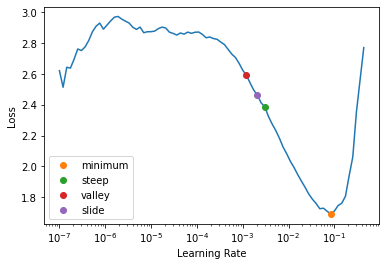

In [87]:
lr_min, lr_steep, lr_valley, lr_slide = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [88]:
print(lr_steep)
learn.fine_tune(6, base_lr=lr_steep)





0.0030199517495930195


epoch,train_loss,valid_loss,accuracy,time
0,2.322773,1.918730,0.280000,00:09


epoch,train_loss,valid_loss,accuracy,time
0,1.293175,1.754308,0.240000,00:11
1,1.034710,1.919991,0.320000,00:11
2,0.848381,2.304124,0.460000,00:11
3,0.682845,2.210078,0.500000,00:11
4,0.572864,2.199906,0.520000,00:11
5,0.482350,2.203519,0.520000,00:11


In [89]:
set_seed(seed_val)
learn = cnn_learner(dls, resnet18, metrics=accuracy)

learn.fit_one_cycle(4, lr_steep)

epoch,train_loss,valid_loss,accuracy,time
0,2.357515,2.554958,0.260000,00:09
1,1.638626,1.981836,0.360000,00:09
2,1.264022,2.371717,0.320000,00:09
3,1.003520,2.462786,0.380000,00:09


In [90]:
learn.unfreeze()
learn.fit_one_cycle(8, lr_max=slice(lr_steep/1000, lr_steep/10))

epoch,train_loss,valid_loss,accuracy,time
0,0.586062,2.533713,0.380000,00:11
1,0.509656,2.700366,0.380000,00:11
2,0.460816,2.807075,0.380000,00:11
3,0.409930,2.879160,0.380000,00:11
4,0.375748,2.809845,0.380000,00:11
5,0.339617,2.797782,0.400000,00:11
6,0.306141,2.797531,0.440000,00:11
7,0.285208,2.798027,0.400000,00:11


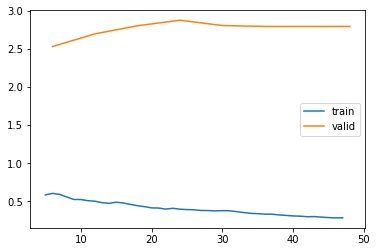

In [91]:
learn.recorder.plot_loss()

### Question 3: How did you select the number of epochs and learning rates? 

In [92]:
lr_steep

0.0030199517495930195

*A learning rate of `lr_steep` (0.00301....) was chosen, as this rate resulted in the best changes in loss.*

*Training was initially done for 12 epochs, but it was found that this caused overfitting. Analysis of the epochs showed that `accuracy_multi` was highest at 8 epochs, so the model was retrained from scratch, but only trained for 8 epochs after unfreezing.*

## 2.2 Experiment with different batch sizes
Using the pipeline, number of epochs, learning rates from above, re-run the pipeline with a batch size of 16, 64

In [93]:
for b_size in [16, 64]:
  print(f'batch size: {b_size}')
  dls = fingers.dataloaders(path, bs=b_size)
  set_seed(seed_val)
  learn = cnn_learner(dls, resnet18, metrics=accuracy)
  learn.fit_one_cycle(3, lr_steep)
  learn.unfreeze()
  learn.fit_one_cycle(8, lr_max=slice(lr_steep/1000, lr_steep/10))

batch size: 16


epoch,train_loss,valid_loss,accuracy,time
0,2.027365,1.853008,0.300000,00:09
1,1.413452,1.910516,0.440000,00:09
2,1.134988,2.084110,0.540000,00:09


epoch,train_loss,valid_loss,accuracy,time
0,0.484561,2.081442,0.500000,00:12
1,0.482551,2.179907,0.480000,00:14
2,0.487809,2.214628,0.480000,00:13
3,0.422130,2.086251,0.520000,00:11
4,0.370524,2.143459,0.500000,00:11
5,0.353061,2.204429,0.480000,00:11
6,0.311545,2.195144,0.500000,00:11
7,0.282705,2.204854,0.520000,00:11


batch size: 64


epoch,train_loss,valid_loss,accuracy,time
0,2.649677,3.398047,0.260000,00:10
1,1.888098,2.519597,0.240000,00:10
2,1.523235,1.934948,0.280000,00:10


epoch,train_loss,valid_loss,accuracy,time
0,0.666023,1.651063,0.380000,00:12
1,0.583699,1.634078,0.360000,00:12
2,0.627136,1.738035,0.340000,00:12
3,0.588363,1.802372,0.460000,00:12
4,0.557059,1.831783,0.460000,00:12
5,0.512873,1.846461,0.480000,00:12
6,0.478361,1.878009,0.520000,00:12
7,0.441902,1.907618,0.520000,00:12


### Question 4: Keeping number of epochs and learning rates the same, how are validation loss and accuracy effected by the increase and decrease of batch size? 
*16 and 64 batches resulted in better validation loss and accuracy in comparison with 32 batches. 64 batches had slightly better validation loss. Overall, the model is performing poorly (regardless of batch size). More or better data may be needed.*



# 3. Analyze model performance
Retrain the model with batch size of 32 from the previous section.

Plot the confusion matrix.

In [94]:
  dls = fingers.dataloaders(path, bs=32)
  set_seed(seed_val)
  learn = cnn_learner(dls, resnet18, metrics=accuracy)
  learn.fit_one_cycle(3, lr_steep)
  learn.unfreeze()
  learn.fit_one_cycle(8, lr_max=slice(lr_steep/1000, lr_steep/10))

epoch,train_loss,valid_loss,accuracy,time
0,2.340151,2.077710,0.360000,00:09
1,1.669414,1.978349,0.320000,00:09
2,1.298206,1.949053,0.380000,00:09


epoch,train_loss,valid_loss,accuracy,time
0,0.630954,1.813732,0.380000,00:11
1,0.608888,1.818605,0.440000,00:11
2,0.569433,1.977766,0.400000,00:11
3,0.500722,2.005895,0.440000,00:11
4,0.447942,1.996786,0.460000,00:11
5,0.417006,1.996799,0.460000,00:11
6,0.380207,2.018733,0.480000,00:11
7,0.359237,2.017578,0.480000,00:11


[('two', 'three', 6),
 ('four', 'three', 4),
 ('three', 'two', 4),
 ('five', 'four', 3),
 ('one', 'two', 3),
 ('five', 'three', 1),
 ('five', 'two', 1),
 ('four', 'two', 1),
 ('three', 'four', 1),
 ('three', 'one', 1),
 ('two', 'four', 1)]

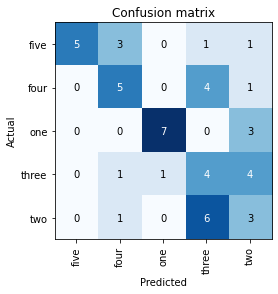

In [95]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
interp.most_confused()

# 4. Save the best model to file
Save the model using `learn.export()` as `.pkl` file. Verify that the model can be reloaded and used to make predictions.

In [98]:
# 16 and 64 batches were the same, and both were better than 32 batches. Used 64 batches as it had lower validation loss.
dls = fingers.dataloaders(path, bs=64)
set_seed(seed_val)
learn = cnn_learner(dls, resnet18, metrics=accuracy)
learn.fit_one_cycle(3, lr_steep)
learn.unfreeze()
learn.fit_one_cycle(8, lr_max=slice(lr_steep/1000, lr_steep/10))


learn.export(path/'../lab3_finger_count.pkl')
learn2 = load_learner(path/'../lab3_finger_count.pkl')

learn2.predict(path/'valid/one/00000000.jpg')

epoch,train_loss,valid_loss,accuracy,time
0,2.373203,3.027996,0.260000,00:10
1,1.805876,2.169600,0.260000,00:10
2,1.463777,1.879418,0.280000,00:10


epoch,train_loss,valid_loss,accuracy,time
0,0.812567,1.865012,0.300000,00:12
1,0.653317,1.897453,0.320000,00:12
2,0.640168,1.875356,0.340000,00:12
3,0.575332,1.858282,0.440000,00:12
4,0.539003,1.814573,0.480000,00:12
5,0.510474,1.826820,0.480000,00:12
6,0.473469,1.858788,0.500000,00:12
7,0.449955,1.866548,0.480000,00:12


('one', TensorBase(2), TensorBase([0.0152, 0.0652, 0.6829, 0.0046, 0.2322]))

# 5. Summary and Conclusion

Summarize:
- Augmentations used
- Training strategy, including batch size, number of epochs and learning rates.
- Accuracy achieved, summary of confusion matrix

*Augmentations used: minimal rotation, horizontal flipping, perspective warping, brightness changes and contrast changes. Zoom not used in case clipping of fingers occurred.*

*Training strategy: used base learning rate of `lr_steep` from the `lr_find()` function, which was approximately 0.003. For later epochs, the slice method was used to provide interpolated learning rates somewhere between `lr_steep/1000` and `lr_steep/10`.*

*Confusion Matrix: the model appears to get very confused with twos and threes. Perhaps better imagery that distinguishes these two is needed.*




Conclusion:
- Are you satisfied with model performance? Why, why not?

*I would not be satisfied with these results in the real world. I would probably try to get a much bigger dataset (or higher quality) and start over.*


# 6.Reflection
Include a sentence or two about
- what you liked or disliked,
- found interesting, confusing, challangeing, motivating

while working on this assignment.

*I enjoyed using real data and learning about the practical problems behind developing a deep learning model. I found it challenging to improve the model score, but ultimately I think it comes down to having poor data. It will be interesting to see if the model can be improved!*
